In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from matplotlib import pyplot as plt

import add_path
from toolkit.pipeline.global_settings import GLOBAL_SETTINGS
from toolkit.pipeline.data_io import (get_existing_sessions, get_session_selection,
    SessionDirectory, save_optotagged_sessions, get_optotagged_sessions)
from toolkit.allen_helpers.units import GENOTYPES, OPTO_GENOTYPES
from toolkit.pipeline.units import OPTO_EVOKE_KEYS
from toolkit.pipeline.units import detect_optotag
from toolkit.plots.plots import plot_optotag_evoke_ratio, plot_optotag_units

## Config

In [2]:
session_set = 'all'  # 'all', 'selected', 'test'

ecephys_structure_acronym = GLOBAL_SETTINGS['ecephys_structure_acronym']

# get existing sessions in the data cache directory
session_list, missing_sessions = get_existing_sessions(session_set, structure_acronym=ecephys_structure_acronym)

sessions_df = get_session_selection().loc[session_list]
session_list = sessions_df.index[sessions_df['has_lfp_data']].tolist()

In [3]:
overwrite_results = False

overwrite_results = overwrite_results and session_set == 'all'

## Get optotagging sessions

In [4]:
units_info_dfs = []
optotagged_sessions = {}

for session_id in session_list:
    session_dir = SessionDirectory(session_id, ecephys_structure_acronym)

    if not session_dir.exist:
        print(f"Failed to load session {session_id}: session directory does not exist")
    elif not session_dir.has_lfp_data: # skip if no lfp data
        print(f"Skip loading session {session_id}: no lfp data")
    else:
        # lasers were used for opto stimulation since session 789848216
        using_laser = session_id >= 789848216

        units_info = session_dir.load_units_info()
        units_info['session_id'] = session_id
        units_info['using_laser'] = using_laser
        units_info_dfs.append(units_info)
        # check if the session is optotagged, has opto stimulation data
        genotype = units_info.iloc[0]['genotype']
        if genotype in OPTO_GENOTYPES and \
            not units_info[OPTO_EVOKE_KEYS].isna().all(axis=None):
            optotagged_sessions[session_id] = dict(using_laser=using_laser, genotype=genotype)

units_info = pd.concat(units_info_dfs)

In [5]:
if overwrite_results:
    # Save optotagged sessions to the results directory
    optotagged_sessions_df = pd.DataFrame.from_dict(optotagged_sessions, orient='index')
    save_optotagged_sessions(optotagged_sessions_df,
        structure_acronym=ecephys_structure_acronym, session_selection=sessions_df)

# Load optotagged sessions from the results directory
optotagged_sessions_df = get_optotagged_sessions().loc[optotagged_sessions.keys()]

### Filter sessions

In [6]:
# Select sessions
session_selection = np.ones(len(optotagged_sessions_df), dtype=bool)
# session_selection &= optotagged_sessions_df['selected']
# session_selection &= optotagged_sessions_df['using_laser']
# session_selection &= optotagged_sessions_df['session_type'] == 'functional_connectivity'

selected_sessions_df = optotagged_sessions_df.loc[session_selection]
print(f"Number of selected sessions: {len(selected_sessions_df)}")
for genotype in OPTO_GENOTYPES:
    print(f"{genotype}: {sum(selected_sessions_df['genotype'] == genotype)}")


from_selected = False
if from_selected:
    # Select units from selected sessions
    selected_units_df = units_info.loc[units_info['session_id'].isin(selected_sessions_df.index)]
    genotypes = OPTO_GENOTYPES
else:
    # Select all including non-optotagged sessions
    selected_units_df = units_info
    genotypes = GENOTYPES

genotype_units = {}
print(f"\nNumber of selected units: {len(selected_units_df)}")
for genotype in genotypes:
    genotype_units[genotype] = selected_units_df.index[selected_units_df['genotype'] == genotype]
    print(f"{genotype}: {len(genotype_units[genotype])}")

Number of selected sessions: 19
Pvalb: 7
Sst: 12

Number of selected units: 3570
Pvalb: 347
Sst: 795
Vip: 535
wt: 1893


## Unit Features

In [7]:
min_rate = 1.  # Hz (minimum rate to avoid 0 firing rate)
evoked_ratio_threshold = 1.5  # threshold for ratio of evoked to baseline
ttest_alpha = 0.1  # alpha for t-test

spike_width_ranges = {'Pvalb': (-np.inf, 0.45), 'Sst': None, 'wt': None, 'Vip': None, 'RS': (0.45, np.inf)}  # ms. Spike width lower than this are PV

In [8]:
optotag_dfs = {}
for genotype in genotypes:
    optotag_dfs[genotype], _ = detect_optotag(
        selected_units_df.loc[genotype_units[genotype]],
        min_rate=min_rate, evoked_ratio_threshold=evoked_ratio_threshold,
        ttest_alpha=ttest_alpha, spike_width_range=spike_width_ranges[genotype]
    )

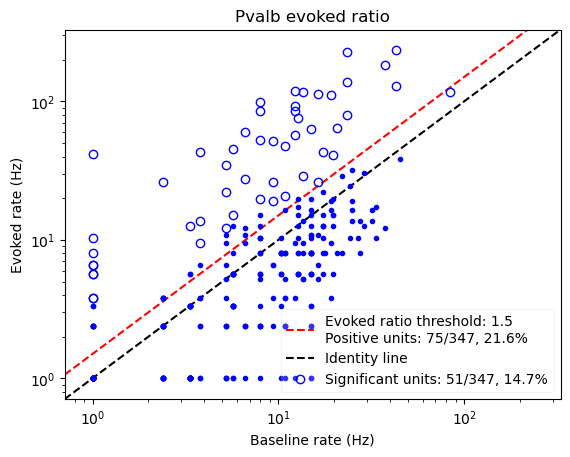

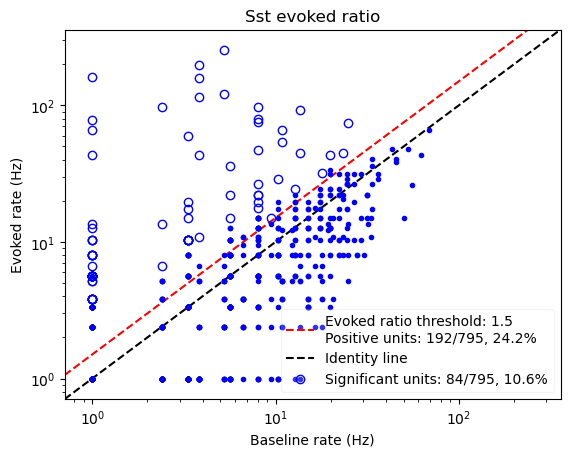

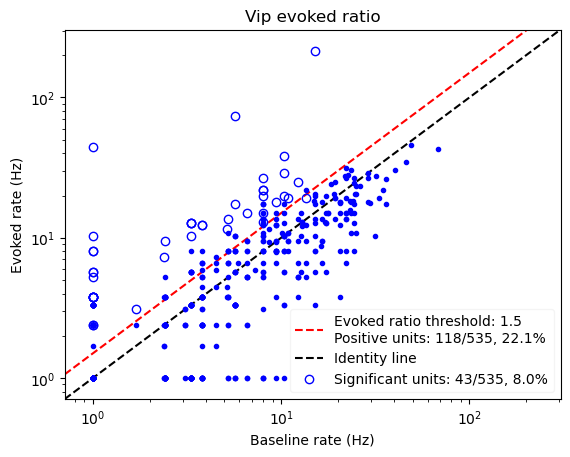

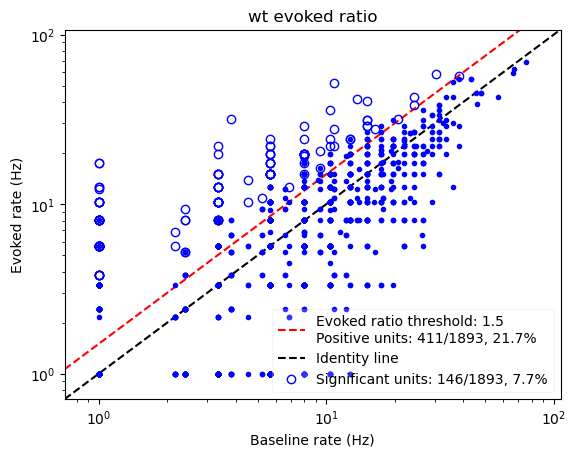

In [9]:
for genotype in genotypes:
    optotag_df = optotag_dfs[genotype]
    ax = plot_optotag_evoke_ratio(optotag_df, min_rate=min_rate, evoked_ratio_threshold=evoked_ratio_threshold)
    ax.set_title(f'{genotype} evoked ratio')

plt.show()

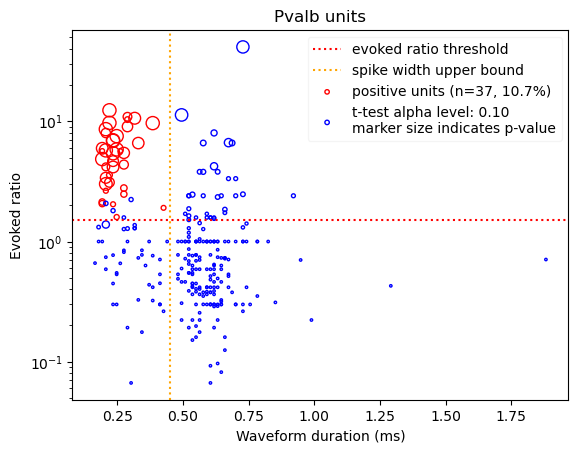

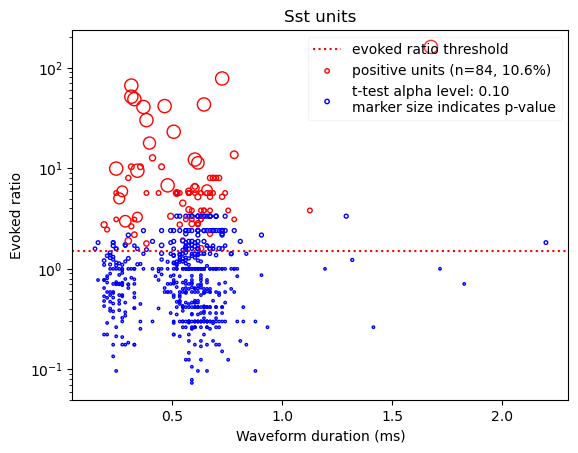

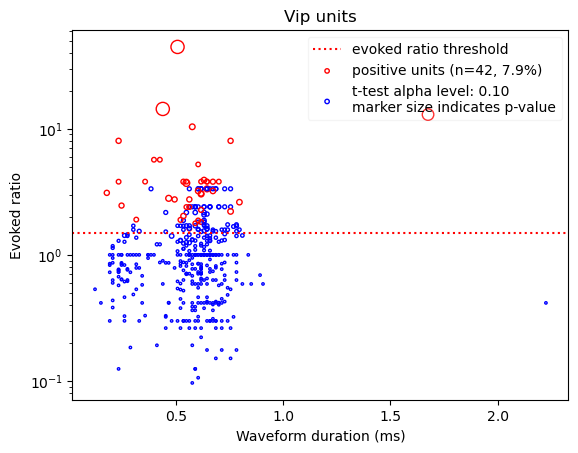

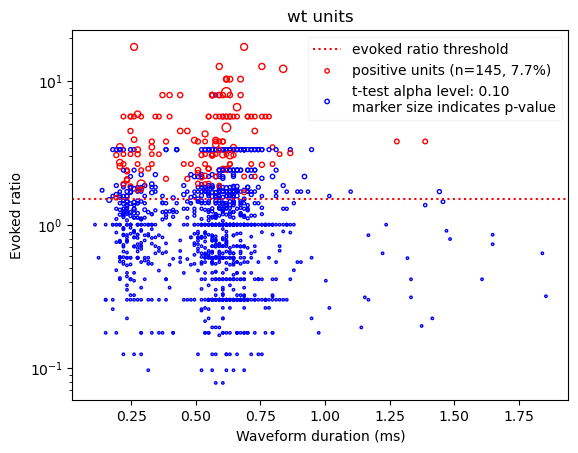

In [10]:
for genotype in genotypes:
    optotag_df = optotag_dfs[genotype]
    ax = plot_optotag_units(optotag_df, ttest_alpha=ttest_alpha,
        evoked_ratio_threshold=evoked_ratio_threshold, spike_width_range=spike_width_ranges[genotype])
    ax.set_title(f'{genotype} units')
plt.show()

In [11]:
import seaborn as sns
from toolkit.plots.colors import VISP_LAYER_ACRONYMS, VISP_LAYER_COLORS_DICT

feature_keys = [
    'evoked_ratio', 'opto_p_value', 'waveform_duration',
    'firing_rate', 'waveform_spread', 'layer_acronym'
]
discrete_keys = dict(layer_acronym=('layer', VISP_LAYER_ACRONYMS))
log_value_keys = ('evoked_ratio', 'firing_rate')
log_minor_ticks = 5
thresholds = dict(
    evoked_ratio=(evoked_ratio_threshold, np.inf),
    opto_p_value=(-np.inf, ttest_alpha),
    waveform_duration=spike_width_ranges
)

# hue = dict(hue='layer_acronym', hue_order=VISP_LAYER_ACRONYMS, palette=VISP_LAYER_COLORS_DICT)
# hue_title = "Layer"
hue = dict(hue='optotag_positive', hue_order=(True, False), palette={True: 'tab:red', False: 'tab:blue'})
hue_title = {genotype: genotype.title() + ' positive' for genotype in genotypes}

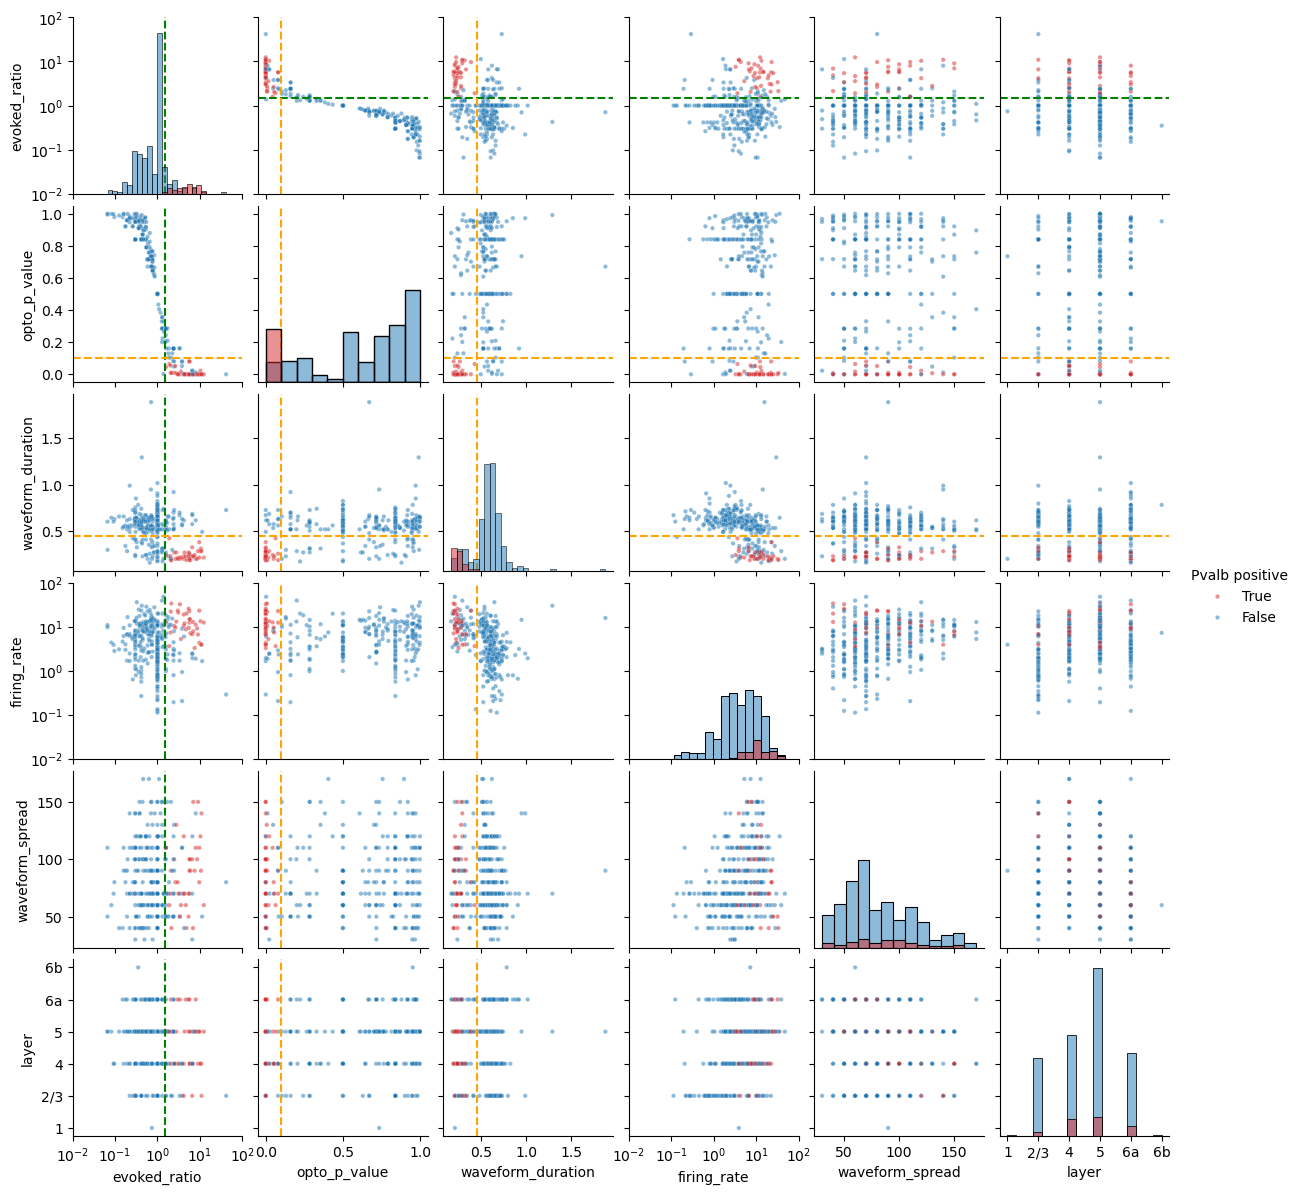

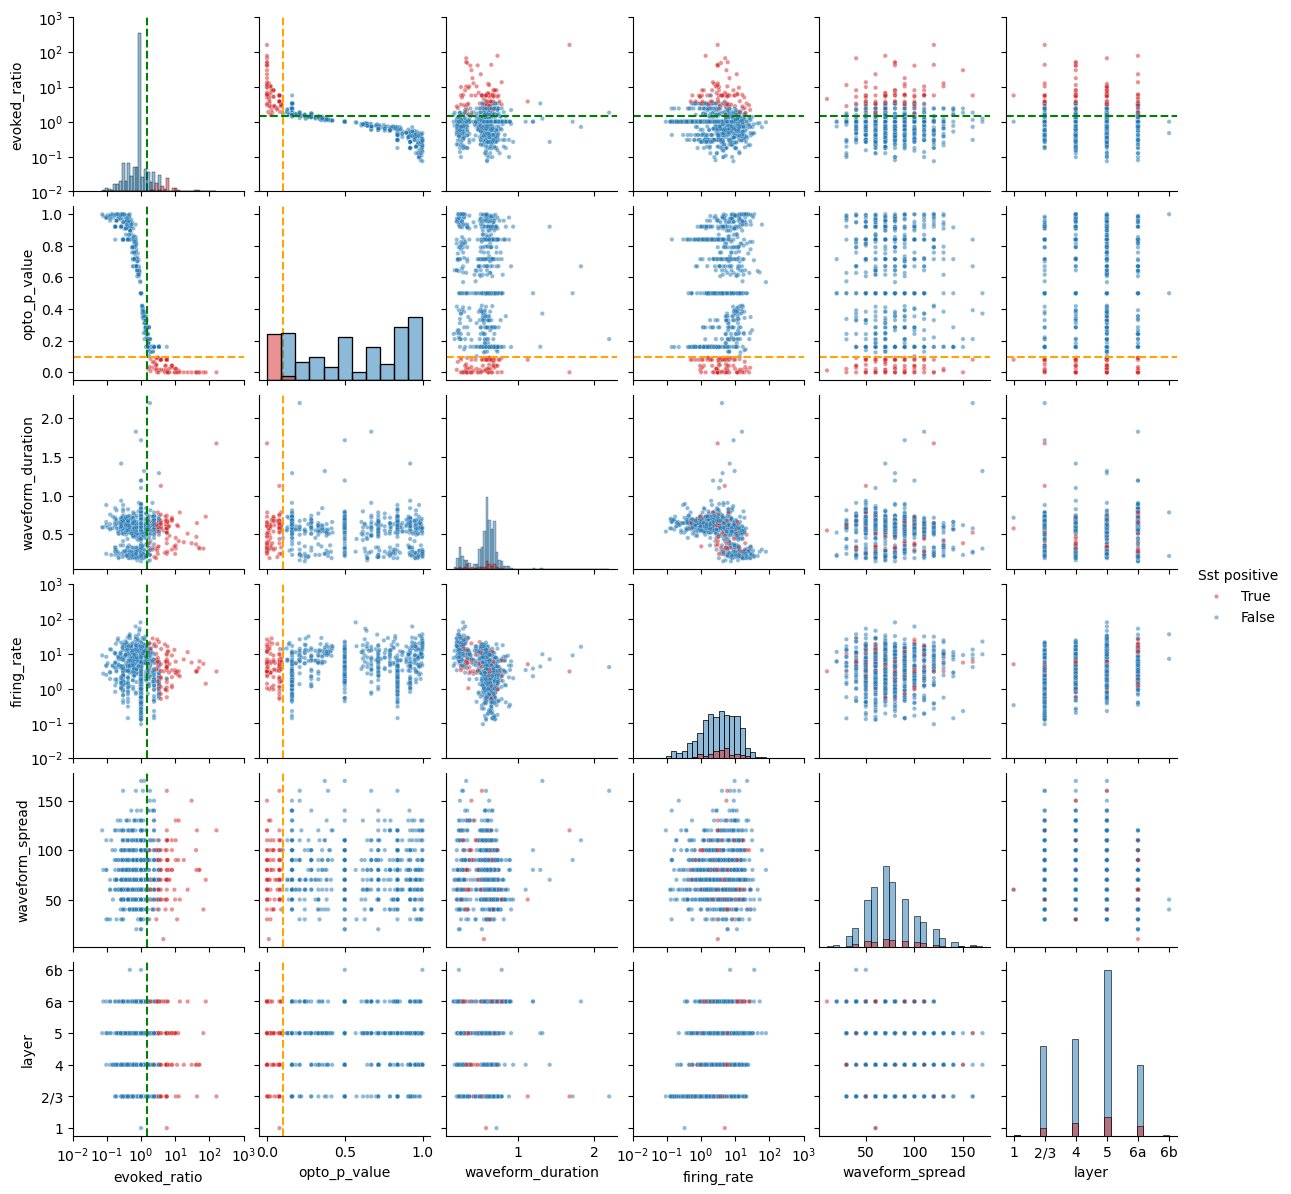

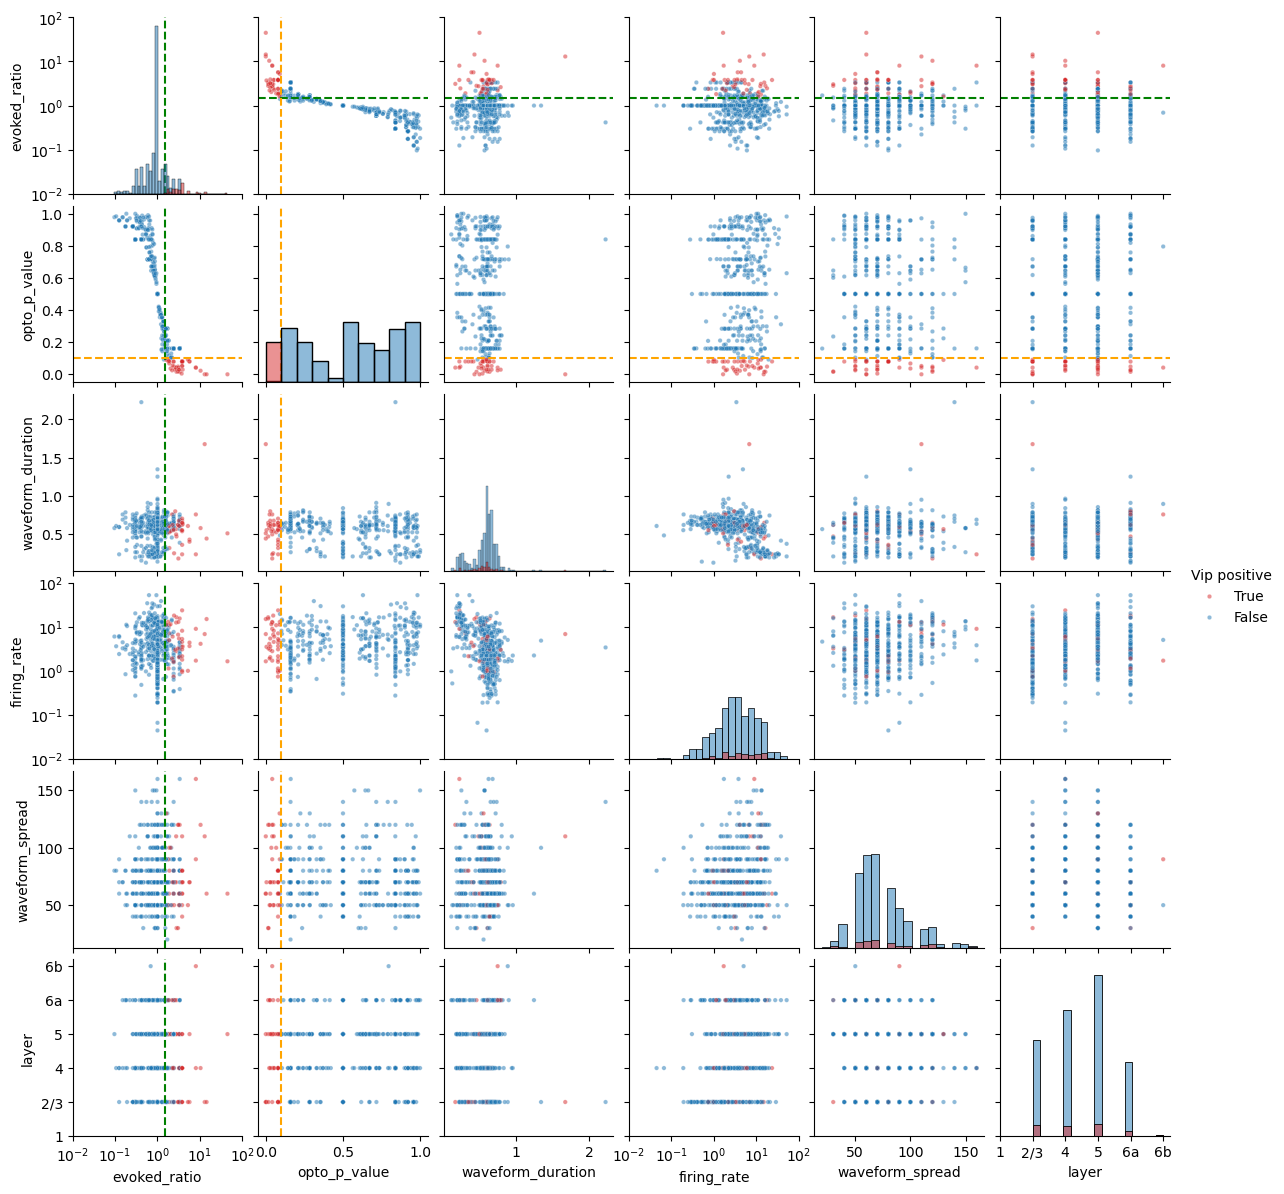

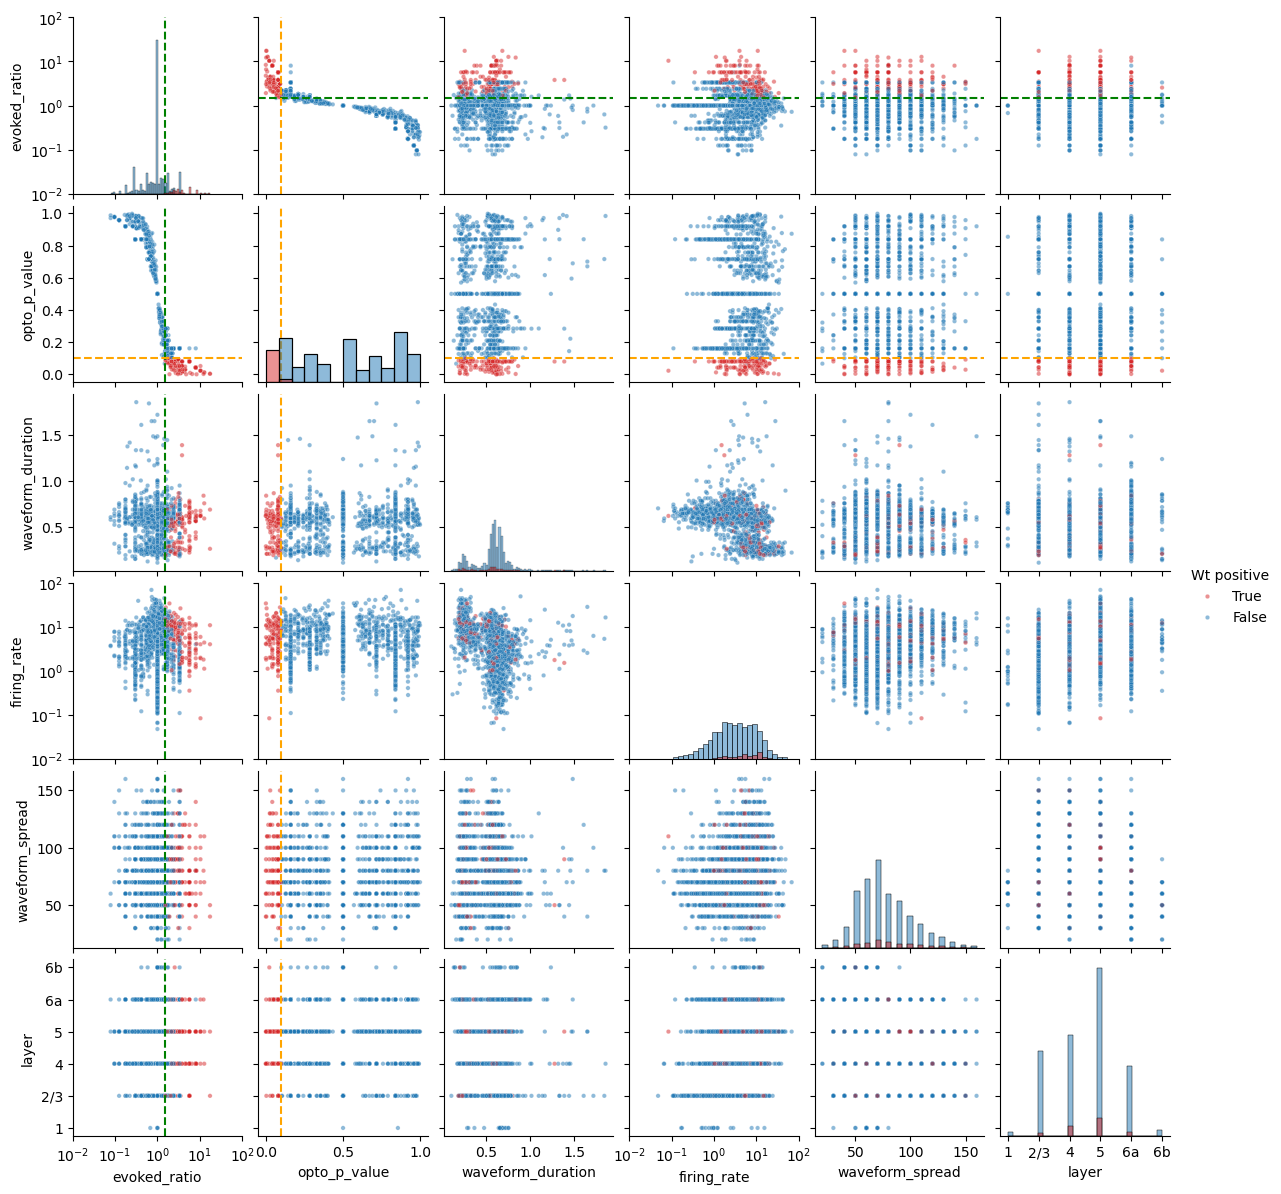

In [12]:
for genotype in genotypes:
    df = optotag_dfs[genotype][feature_keys].copy()
    for key in log_value_keys:
        df[key] = np.log10(df[key])
    for key, (order_key, order) in discrete_keys.items():
        order_map = dict(zip(order, range(len(order))))
        df[key] = df[key].map(order_map)
        df.rename(columns={key: order_key}, inplace=True)
    if hue:
        hue_key = hue_title[genotype] if isinstance(hue_title, dict) else hue_title
        df[hue_key] = optotag_dfs[genotype][hue['hue']]
        hue_kwargs = hue | dict(hue=hue_key)

    g = sns.pairplot(df, diag_kind='hist', height=2.,
        plot_kws=dict(s=10, alpha=0.5), **hue_kwargs)
    axs = g.axes
    # Update axis tick labels of variables
    for key in log_value_keys:
        i = feature_keys.index(key)
        for ax, a in zip((axs[-1, i], axs[i, 0]), ('x', 'y')):
            xl = getattr(ax, f'get_{a}lim')()
            ticks = np.arange(np.floor(xl[0]), np.ceil(xl[1]) + 1, dtype=int)
            getattr(ax, f'set_{a}ticks')(ticks, labels=map('$10^{{{}}}$'.format, ticks))
    for key, (_, order) in discrete_keys.items():
        i = feature_keys.index(key)
        for ax, a in zip((axs[-1, i], axs[i, 0]), ('x', 'y')):
            getattr(ax, f'set_{a}ticks')(np.arange(len(order)), labels=order)
    # Add threshold lines
    for key, threshold in thresholds.items():
        if isinstance(threshold, dict):
            threshold = threshold[genotype]
        if threshold is None:
            continue
        i = feature_keys.index(key)
        for j, clr in enumerate(('g', 'orange')):  # lower, upper bounds
            t = threshold[j]
            if np.isinf(t):
                continue
            if key in log_value_keys:
                t = np.log10(t)
            for ax in np.delete(axs[i, :], i):
                ax.axhline(t, color=clr, linestyle='--')
            for ax in axs[:, i]:
                ax.axvline(t, color=clr, linestyle='--')

plt.show()